### OCI Data Science - Useful Tips
<details>
<summary><font size="2">Check for Public Internet Access</font></summary>

```python
import requests
response = requests.get("https://oracle.com")
assert response.status_code==200, "Internet connection failed"
```
</details>
<details>
<summary><font size="2">Helpful Documentation </font></summary>
<ul><li><a href="https://docs.cloud.oracle.com/en-us/iaas/data-science/using/data-science.htm">Data Science Service Documentation</a></li>
<li><a href="https://docs.cloud.oracle.com/iaas/tools/ads-sdk/latest/index.html">ADS documentation</a></li>
</ul>
</details>
<details>
<summary><font size="2">Typical Cell Imports and Settings for ADS</font></summary>

```python
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import logging
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.ERROR)

import ads
from ads.dataset.factory import DatasetFactory
from ads.automl.provider import OracleAutoMLProvider
from ads.automl.driver import AutoML
from ads.evaluations.evaluator import ADSEvaluator
from ads.common.data import ADSData
from ads.explanations.explainer import ADSExplainer
from ads.explanations.mlx_global_explainer import MLXGlobalExplainer
from ads.explanations.mlx_local_explainer import MLXLocalExplainer
from ads.catalog.model import ModelCatalog
from ads.common.model_artifact import ModelArtifact
```
</details>
<details>
<summary><font size="2">Useful Environment Variables</font></summary>

```python
import os
print(os.environ["NB_SESSION_COMPARTMENT_OCID"])
print(os.environ["PROJECT_OCID"])
print(os.environ["USER_OCID"])
print(os.environ["TENANCY_OCID"])
print(os.environ["NB_REGION"])
```
</details>

In [35]:
 
# Some useful libraries
import numpy as np
import scipy as sp
import math

#Pandas for data structure and analysis tools
import pandas as pd

import seaborn as sns
#seaborn and matplotlib for plotting
import matplotlib.pyplot as plt

from numpy.random import default_rng
from sklearn import cluster
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
np.random.seed(42) # Fixed seed for reproducibility
rng = default_rng()

In [36]:
df = pd.read_csv("nba_per_game_2021_2022.csv")
df2 = pd.read_csv("nba_advanced_2021_2022.csv")

In [37]:
#only want players that have played at least 20 games and are not biased with a small trade deadline sample space
df2 = df2[df2.G >= 20]
df2 = df2[df2.Tm != 'TOT']
df = df[df.G >= 20]
df = df[df.Tm != 'TOT']


In [38]:
#merge advanced stats and per-game stats to centers
df_m = df2.merge(df[['Player', 'Pos', 'MP', 'TRB', 'AST', 'STL', 'PTS']], on = 'Player', how = 'left')
df_c = df_m.loc[df_m['Pos_x'] == 'C']
df_pg = df_m.loc[df_m['Pos_x'] == 'PG']
df_pg_2 = df_m.loc[df_m['Pos_x'] == 'SG-PG']
df_pg = pd.concat([df_pg, df_pg_2])

In [39]:
#we can get other positions as well if needed but for now, we leave this commented
'''
or df_m['Pos_x'] == 'C-PF'
df_pf = df_m.loc[df_m['Pos_x'] == 'PF' or df_m['Pos_x'] == 'PF-SF' or df_m['Pos_x'] == 'PF-SG']
df_pg = df_m.loc[df_m['Pos_x'] == 'PG' or df_m['Pos_x'] == 'SG-PG']
df_sf = df_m.loc[df_m['Pos_x'] == 'SF' or df_m['Pos_x'] == 'SF-SG']
df_sg = df_m.loc[df_m['Pos_x'] == 'PG' or df_m['Pos_x'] == 'SG-PG' or df_m['Pos_x'] == 'SG-SF']
'''

"\nor df_m['Pos_x'] == 'C-PF'\ndf_pf = df_m.loc[df_m['Pos_x'] == 'PF' or df_m['Pos_x'] == 'PF-SF' or df_m['Pos_x'] == 'PF-SG']\ndf_pg = df_m.loc[df_m['Pos_x'] == 'PG' or df_m['Pos_x'] == 'SG-PG']\ndf_sf = df_m.loc[df_m['Pos_x'] == 'SF' or df_m['Pos_x'] == 'SF-SG']\ndf_sg = df_m.loc[df_m['Pos_x'] == 'PG' or df_m['Pos_x'] == 'SG-PG' or df_m['Pos_x'] == 'SG-SF']\n"

In [40]:
#select basic and advanced stats unique to good centers
df_c_selected_terms = df_c[['ORB%', 'PTS', 'TRB', 'MP_y', 'PER', 'DRB%', 'TRB%', 'TS%', 'BLK%', 'OWS', 'DWS', 'WS', 'BPM', 'VORP']]
df_pg_selected_terms = df_pg[['PTS', 'AST', 'AST%', 'USG%', 'STL', 'TOV%', 'MP_y', 'PER', 'OWS', 'DWS', 'WS', 'WS/48', 'BPM', 'OBPM', 'VORP']]

In [41]:
#KMeans clustering
import warnings
warnings.filterwarnings('ignore')
kmeans_c = KMeans(n_clusters=6)
y = kmeans_c.fit_predict(df_c_selected_terms)
df_c['Cluster'] = y
Y_labels = df_c['Cluster'].to_numpy()


In [42]:
y_pg = kmeans_c.fit_predict(df_pg_selected_terms)
df_pg['Cluster'] = y_pg
Y_pg_labels = df_pg['Cluster'].to_numpy()

In [46]:
#sort centers by labels
print("Average: ")
print(df_c[df_c['Cluster'] == 0])
print("All-Star: ")
print(df_c.loc[df_c['Cluster'] == 1])
print("Inconsistent role in Rotation: ")
print(df_c.loc[df_c['Cluster'] == 2])
print("Solid Role Player: ")
print(df_c.loc[df_c['Cluster'] == 3])
print("Superstar: ")
print(df_c.loc[df_c['Cluster'] == 4])
print("Fringe Rotation: ")
print(df_c.loc[df_c['Cluster'] == 5])
my_array = df_c_selected_terms.to_numpy()

Average: 
      Rk                       Player Pos_x  Age   Tm   G  MP_x   PER    TS%  \
51    63       Tony Bradley\bradlto01     C   24  CHI  43   488  14.8  0.599   
62    76        Moses Brown\brownmo01     C   22  DAL  26   169  15.7  0.588   
98   129     Dewayne Dedmon\dedmode01     C   32  MIA  50   820  17.3  0.649   
101  136       Gorgui Dieng\dienggo01     C   32  ATL  36   327  17.3  0.617   
106  148     Andre Drummond\drumman01     C   28  PHI  49   902  19.8  0.544   
114  160       Drew Eubanks\eubandr01     C   24  SAS  49   595  16.3  0.588   
123  173       Enes Freedom\kanteen01     C   29  BOS  35   411  15.3  0.585   
161  229  Willy Hernangómez\hernawi01     C   27  NOP  29   480  23.0  0.586   
172  247      Dwight Howard\howardw01     C   36  LAL  41   594  18.3  0.657   
199  293     DeAndre Jordan\jordade01     C   33  LAL  31   399  17.7  0.657   
247  359       JaVale McGee\mcgeeja01     C   34  PHO  50   811  24.7  0.671   
383  567   Hassan Whiteside\wh

In [44]:
 # we have a large dimensional array, so let's use TSNE to reduce dimensions to display
tsne = TSNE(n_components=2, random_state=0)
tsne_obj = tsne.fit_transform(my_array)
#create new DF for the TSNE reduced dimensions/cant use PSA with nonlinear datasets
res_tsne = pd.DataFrame({'X_scaled': tsne_obj[:,0], 'Y_scaled': tsne_obj[:,1], 'results': Y_labels})

res_tsne.results = res_tsne.results.astype(str)


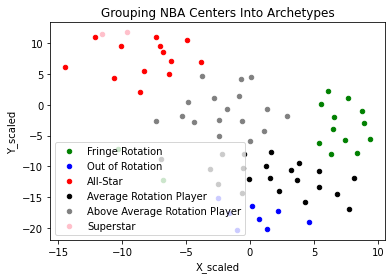

In [47]:
#plot code 

ax = res_tsne[res_tsne.results == '0'].plot.scatter('X_scaled', 'Y_scaled', color='green')
res_tsne[res_tsne.results == '1'].plot.scatter('X_scaled', 'Y_scaled', ax=ax, color='blue')
res_tsne[res_tsne.results == '2'].plot.scatter('X_scaled', 'Y_scaled', ax=ax, color='red')
res_tsne[res_tsne.results == '3'].plot.scatter('X_scaled', 'Y_scaled', ax=ax, color='black')
res_tsne[res_tsne.results == '4'].plot.scatter('X_scaled', 'Y_scaled', ax=ax, color='grey')
res_tsne[res_tsne.results == '5'].plot.scatter('X_scaled', 'Y_scaled', ax=ax, color='pink')
plt.title("Grouping NBA Centers Into Archetypes")
plt.legend(['Fringe Rotation', 'Out of Rotation', 'All-Star', 'Average Rotation Player', 'Above Average Rotation Player', 'Superstar'])
plt.show()